## 1d slab example for MaxwellSALT

First, install the MaxwellSALT package using the instructions at github.com/wsshin/MaxwellSALT.jl. Then, load the MaxwellSALT package and create a blank SALT object, which will contain all the parameters of our laser simulation:

In [74]:
using MaxwellSALT
salt=SALT()
set_unitlen!(salt,1e-3)

Note we have made the unit length $1 \mathrm{mm} = 10^{-3} \mathrm{m}$, e.g. a length of 5 means 5 mm. Now let's input some parameters for a simple 1d structure consisting of a slab of uniform dielectric surrounded on both sides by air going to infinity, which we represent computationally using a finite region of air terminated by a perfectly matched layer (PML).

We make the slab 1 mm thick, and use 100 grid points to discretize it:

In [75]:
Lslab=1
Nslab=100
∆x=Lslab/Nslab;

(note that the triangle symbol here is \increment, not \Delta). 

We also need to account for the air and PML in both directions. Let's make 20 pixels of air plus 10 pixels of PML in each direction, then compute the total length of the cell in the x direction accordingly:

In [76]:
Nair=20
Npml=10
Lx=Lslab+2*(Nair+Npml)*∆x
Ly,Lz=1,1;

Note that for the y and z directions, everything is uniform and infinite, which we will model using periodic boundary conditions. Hence, set the dimensions to whatever.

Next, set the coordinate bounds to go from 0 to L for all three coordinates, and for y and z directions, have only a single pixel, making the cell periodic in the y and z directions in order to make the problem 1d:

In [77]:
set_bounds!(salt, ([0,0,0], [Lx,Ly,Lz]))
set_∆l!(salt, [∆x, Ly, Lz])
set_isbloch!(salt, [false,true,true])

Set the PML pixels at the lower and upper ends in the x direction. Note we also need to choose a frequency for the PML. For simplicity, we set that frequency to the same as that of the gain, since in this case we will be looking for modes near there:

In [78]:
ωa,γp=15,3
set_Npml!(salt, ([Npml,0,0], [Npml,0,0]))
set_pmlfreq!(salt,ωa)

Here, γp is the $\gamma_\perp$ Lorentzian relaxation factor from SALT.

Then, we set the background to vacuum with ε=1, and also add the slab itself as an object with uniform ε=2.25, centered at Lx/2 and with a width of Lslab:

In [79]:
set_background!(salt,"Vacuum",1.0)
εslab=2.25
slab=Box([Lx/2,Ly/2,Lz/2],[Lslab,Ly,Lz])
add_obj!(salt,"Dielectric",εslab,slab)

Having completed the specification of the structure and geometry, we can now obtain the cold-cavity dielectric function. Note that every three consecutive elements of this vector contain the xx, yy, and zz diagonal tensor components of the permittivity, so the vector's length is actually three times the number of grid points in the Nx direction:

In [80]:
εc=get_εcold(salt)
Nx=length(εc)÷3;

Let's plot the xx component (the other two components are the same):

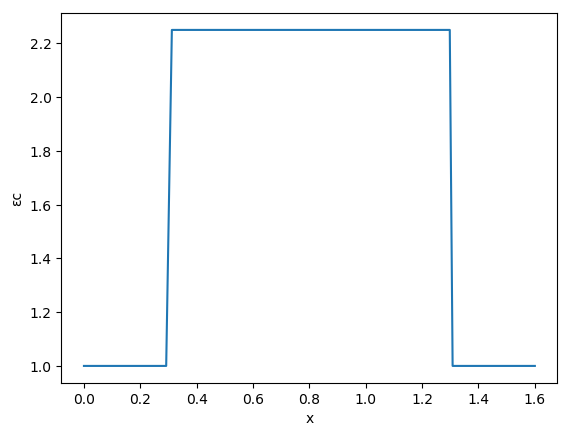

In [81]:
using PyPlot
xs=range(0,stop=Lx,length=Nx)
plot(xs,real(εc[1:3:end]))
xlabel("x")
ylabel("εc");

To perform the simulation, we also need the matrix for the Maxwell curl curl operator:

In [82]:
CC=get_dblcurl(salt);

Now use the linear eigensolver to find the passive modes closest to the gain frequency:

In [83]:
using Arpack: eigs
ω²,ψp=eigs(CC,Diagonal(εc),nev=6,sigma=ωa^2);

Recall that we have chosen ωa^2=225, so let's see what modes we found:

In [84]:
ω²

6-element Array{Complex{Float64},1}:
 217.29140271077918 - 31.677175227601126im
 217.29140271077992 - 31.67717522760141im 
  283.8091663936545 - 36.054601605031245im
  283.8091663936549 - 36.054601605031394im
  159.5072586430092 - 27.248264031334415im
  159.5072586430087 - 27.248264031334333im

The closest pole appears to have ω≈√217.29≈14.74. The poles come in degenerate pairs because of the two possible transverse polarizations. Note that the longitudinal x component of the field is very nearly zero:

In [85]:
norm(ψp[:,1][1:3:end])

5.159597844123551e-17

Additionally, note that the two degenerate modes (the first two columns of the ψp found by eigs above) are not pure y and pure z polarizations, but some linear combination of them, as we can see by plotting the components of the first mode:

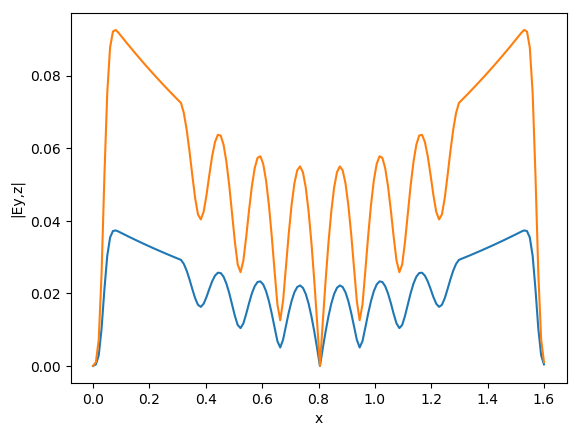

In [86]:
plot(xs,abs.(ψp[:,1][2:3:end]))
plot(xs,abs.(ψp[:,1][3:3:end]))
xlabel("x")
ylabel("|Ey,z|");

For simplicity, let's extract a copy of the first mode, then zero all but its z component, which from the above plot is the largest:

In [87]:
ω=√ω²[1]
ψ=copy(ψp[:,1])
ψ[1:3:end].=0
ψ[2:3:end].=0;

Now let's start pumping the gain. For simplicity, assume that our gain atoms coincide with the dielectric slab, and also that only one atomic class with weight 1.0. Later on, we may use multiple classes with prespecified weights.

In [88]:
set_gainparam!(salt,[ωa],[γp],[1.0])
add_gainobj!(salt,slab)

Now set the initial guess and start the simulation. Note that the system we are computing can be solved exactly using simple semi-analytical transfer matrix methods, and the threshold is approximately 0.36.

In [89]:
set_initguess!(salt,[ω],reshape(ψ,length(ψ),1))
dvec=0:0.01:0.4
ωout, aout, ψout, nAA, tAA = simulate!(salt, dvec, outωaψ=(true,true,true), τr_anderson=1e-6, m_anderson=20);


Start SALT simulation.
d = 0.0:
  Solve lasing eq. with modes m = Int64[] where aₗ²[m=1:1] = [0.0]:
    Initial residual norm: ‖leq₀‖ = Inf
    No. of Anderson steps = 0 (0.000136 sec), ‖leq‖ = 0.000e+00, ‖leq‖/‖leq₀‖ = NaN
    Lasing solution: aₗ² = [0.0], ωₗ = [0.0]
  Solve nonlasing eq. with modes m = [1] where ωₙₗ[m=1:1] = [14.7797-1.07164im]:
    mode 1: No. of Newton steps = 1 (0.000538 sec), ‖nleq‖ = 5.358e-11, ‖nleq‖/‖nleq₀‖ = 1.000e+00
    Nonlasing solution: ωₙₗ = [14.7797-1.07164im]
d = 0.01:
  Solve lasing eq. with modes m = Int64[] where aₗ²[m=1:1] = [0.0]:
    Initial residual norm: ‖leq₀‖ = Inf
    No. of Anderson steps = 0 (0.000056 sec), ‖leq‖ = 0.000e+00, ‖leq‖/‖leq₀‖ = NaN
    Lasing solution: aₗ² = [0.0], ωₗ = [0.0]
  Solve nonlasing eq. with modes m = [1] where ωₙₗ[m=1:1] = [14.7797-1.07164im]:
    mode 1: No. of Newton steps = 3 (0.001455 sec), ‖nleq‖ = 4.560e-05, ‖nleq‖/‖nleq₀‖ = 2.623e-06
    Nonlasing solution: ωₙₗ = [14.7935-1.02137im]
d = 0.02:
  Solve lasin

    No. of Anderson steps = 0 (0.000033 sec), ‖leq‖ = 0.000e+00, ‖leq‖/‖leq₀‖ = NaN
    Lasing solution: aₗ² = [0.0], ωₗ = [0.0]
  Solve nonlasing eq. with modes m = [1] where ωₙₗ[m=1:1] = [14.8799-0.366857im]:
    mode 1: No. of Newton steps = 3 (0.005403 sec), ‖nleq‖ = 2.054e-06, ‖nleq‖/‖nleq₀‖ = 1.363e-07
    Nonlasing solution: ωₙₗ = [14.8812-0.335873im]
d = 0.2:
  Solve lasing eq. with modes m = Int64[] where aₗ²[m=1:1] = [0.0]:
    Initial residual norm: ‖leq₀‖ = Inf
    No. of Anderson steps = 0 (0.000046 sec), ‖leq‖ = 0.000e+00, ‖leq‖/‖leq₀‖ = NaN
    Lasing solution: aₗ² = [0.0], ωₗ = [0.0]
  Solve nonlasing eq. with modes m = [1] where ωₙₗ[m=1:1] = [14.8812-0.335873im]:
    mode 1: No. of Newton steps = 3 (0.000954 sec), ‖nleq‖ = 1.935e-06, ‖nleq‖/‖nleq₀‖ = 1.291e-07
    Nonlasing solution: ωₙₗ = [14.8822-0.30544im]
d = 0.21:
  Solve lasing eq. with modes m = Int64[] where aₗ²[m=1:1] = [0.0]:
    Initial residual norm: ‖leq₀‖ = Inf
    No. of Anderson steps = 0 (0.000038 sec)

    k = 3: ‖leq‖/‖leq₀‖ = 2.7802905885776093e-5
    k = 4: ‖leq‖/‖leq₀‖ = 4.953946429886198e-7
    No. of Anderson steps = 4 (0.016535 sec), ‖leq‖ = 6.338e-06, ‖leq‖/‖leq₀‖ = 4.954e-07
    Lasing solution: aₗ² = [0.259208], ωₗ = [14.8815]
  Solve nonlasing eq. with modes m = Int64[] where ωₙₗ[m=1:1] = [14.8826+0.0im]:
    Nonlasing solution: ωₙₗ = [14.8826+0.0im]
d = 0.37:
  Solve lasing eq. with modes m = [1] where aₗ²[m=1:1] = [0.259208]:
    Initial residual norm: ‖leq₀‖ = Inf
    k = 1: ‖leq‖/‖leq₀‖ = 0.04774691630685301
    k = 2: ‖leq‖/‖leq₀‖ = 0.0035268537996452944
    k = 3: ‖leq‖/‖leq₀‖ = 3.4179196097596805e-5
    k = 4: ‖leq‖/‖leq₀‖ = 8.761489465637319e-7
    No. of Anderson steps = 4 (0.019386 sec), ‖leq‖ = 1.092e-05, ‖leq‖/‖leq₀‖ = 8.761e-07
    Lasing solution: aₗ² = [0.313019], ωₗ = [14.8811]
  Solve nonlasing eq. with modes m = Int64[] where ωₙₗ[m=1:1] = [14.8826+0.0im]:
    Nonlasing solution: ωₙₗ = [14.8826+0.0im]
d = 0.38:
  Solve lasing eq. with modes m = [1] where a

ωout and ψout now contain the frequency and mode at each pump increment. We can plot ωout to see its trajectory in the complex plane:

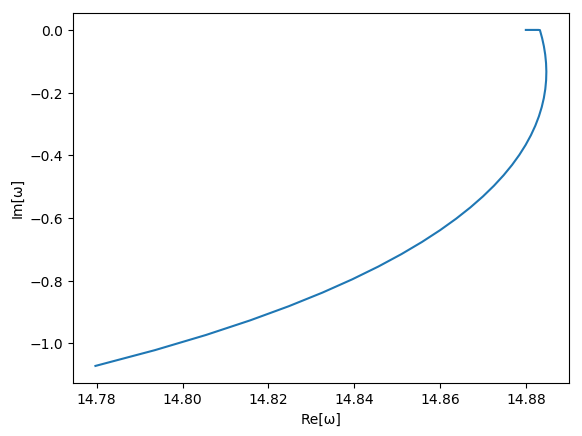

In [90]:
plot(real(ωout[1,:]),imag(ωout[1,:]))
xlabel("Re[ω]")
ylabel("Im[ω]");

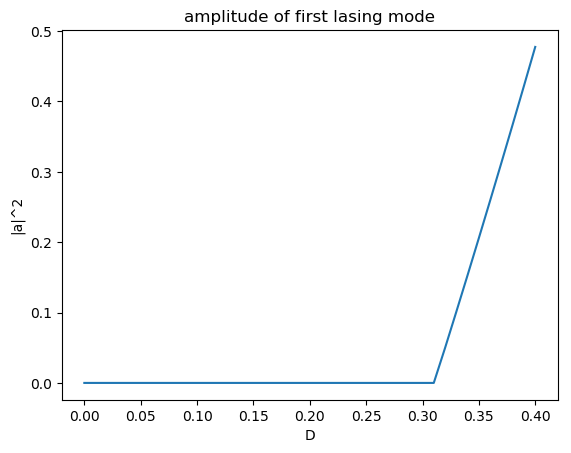

In [96]:
plot(dvec,aout[1,:].^2)
title("amplitude of first lasing mode")
xlabel("D")
ylabel("|a|^2");